<a href="https://colab.research.google.com/github/HofstraDoboli/project-2-ashleyproject2/blob/main/EmployeeAccessChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Employee Access Challenge
Predict an employee's access needs, given his/her job role
## Dataset Description
The data consists of real historical data collected from 2010 & 2011. Employees are manually allowed or denied access to resources over time. You must create an algorithm capable of learning from this historical data to predict approval/denial for an unseen set of employees.

### File Descriptions
**train.csv** - The training set. Each row has the ACTION (ground truth), RESOURCE, and information about the employee's role at the time of approval

**test.csv** - The test set for which predictions should be made. Each row asks whether an employee having the listed characteristics should have access to the listed resource.

### Column Descriptions
| **Column Name**    |   **Description**
| ------------------ | --------------------------------------------------------------------------------------------------------------------- |
| ACTION             |   ACTION is 1 if the resource was approved, 0 if the resource was not                                                 |
| RESOURCE 	         |   An ID for each resource                                                                                             |
| MGR_ID 	         |   The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time   |
| ROLE_ROLLUP_1 	 |   Company role grouping category id 1 (e.g. US Engineering)                                                           |
| ROLE_ROLLUP_2 	 |   Company role grouping category id 2 (e.g. US Retail)                                                                |
| ROLE_DEPTNAME 	 |   Company role department description (e.g. Retail)                                                                   |
| ROLE_TITLE 	     |   Company role business title description (e.g. Senior Engineering Retail Manager)                                    |
| ROLE_FAMILY_DESC   |   Company role family extended description (e.g. Retail Manager, Software Engineering)                                |
| ROLE_FAMILY 	     |   Company role family description (e.g. Retail Manager)                                                               |
| ROLE_CODE 	     |   Company role code; this code is unique to each role (e.g. Manager)                                                  |

## Import Libraries and Datasets

In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.utils.data as dataUtils
from   torch.autograd import Variable
from   torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

import tqdm
import copy
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [2]:
# download the csv file as a pandas Dataframe
dir = "./datasets"
X = pd.read_csv(f"{dir}/Xtrain.csv")
y = pd.read_csv(f"{dir}/yTrain.csv")
X

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
24033,76844,7344,117961,118225,120663,123648,127917,120518,123650
1389,25993,48583,117926,118124,117941,117879,117886,19721,117880
19917,79092,205,117961,118386,118746,118321,117906,290919,118322
22516,15064,49388,118887,118888,118631,118293,301534,118295,118296
2303,25553,13765,117918,117919,117920,145648,123191,119784,163313
...,...,...,...,...,...,...,...,...,...
5929,20298,46788,117929,117940,117920,118568,163031,19721,118570
11039,74001,12240,118090,118091,119424,179731,133533,117887,117973
4220,41643,14638,117961,118052,118821,117905,117906,290919,117908
6682,74701,6299,117961,117962,118501,118321,118448,290919,118322


In [3]:
# Import test set
Xtest = pd.read_csv(f"{dir}/Xtest.csv")
yTest = pd.read_csv(f"{dir}/yTest.csv")["ACTION"].to_numpy()

# Drop Columns
Xtest.drop(["ROLE_DEPTNAME", "ROLE_FAMILY"], axis=1, inplace=True)

## Preprocessing

In [4]:
# Combined dataframe for visualizaiton
combinedDf = X.copy()
combinedDf["ACTION"] = y["ACTION"]
combinedDf = combinedDf.loc[:, ["ACTION"] + list(X.columns)]
combinedDf

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
24033,1,76844,7344,117961,118225,120663,123648,127917,120518,123650
1389,1,25993,48583,117926,118124,117941,117879,117886,19721,117880
19917,1,79092,205,117961,118386,118746,118321,117906,290919,118322
22516,1,15064,49388,118887,118888,118631,118293,301534,118295,118296
2303,1,25553,13765,117918,117919,117920,145648,123191,119784,163313
...,...,...,...,...,...,...,...,...,...,...
5929,1,20298,46788,117929,117940,117920,118568,163031,19721,118570
11039,1,74001,12240,118090,118091,119424,179731,133533,117887,117973
4220,1,41643,14638,117961,118052,118821,117905,117906,290919,117908
6682,1,74701,6299,117961,117962,118501,118321,118448,290919,118322


In [5]:
# Find correlations
corrMatrix = combinedDf.corr()
sortedCorr = corrMatrix.sort_values(by="ACTION", ascending=False) # Sort columns by correlation to label
sortedCorr = sortedCorr.sort_values(by="ACTION", ascending=False, axis=1) # Sort rows

print(sortedCorr)

                    ACTION  ROLE_CODE  ROLE_FAMILY_DESC  ROLE_ROLLUP_2  \
ACTION            1.000000   0.020044          0.009946       0.006315   
ROLE_CODE         0.020044   1.000000          0.095196       0.017259   
ROLE_FAMILY_DESC  0.009946   0.095196          1.000000       0.018019   
ROLE_ROLLUP_2     0.006315   0.017259          0.018019       1.000000   
ROLE_DEPTNAME     0.001889   0.007282         -0.002950      -0.003471   
ROLE_FAMILY      -0.001394  -0.146859         -0.184346       0.070029   
MGR_ID           -0.004053  -0.003715         -0.016186      -0.000586   
RESOURCE         -0.006446   0.003053          0.018002       0.013493   
ROLE_TITLE       -0.009851   0.156860          0.173479       0.005929   
ROLE_ROLLUP_1    -0.015538  -0.024998         -0.011665       0.028801   

                  ROLE_DEPTNAME  ROLE_FAMILY    MGR_ID  RESOURCE  ROLE_TITLE  \
ACTION                 0.001889    -0.001394 -0.004053 -0.006446   -0.009851   
ROLE_CODE              0.

In [6]:
def makeCmap(cMatrix):
  # Range for cmap
  corrFlat = cMatrix.to_numpy().flatten()
  corrFlat = corrFlat[corrFlat < 1]

  minCorr = round(corrFlat.min(), 4) # Find minimum correlation
  maxCorr = round(corrFlat.max(), 4) # Find maximum correlation (excluding 1.00)

  # Find cmap indices
  corrRange = list(np.arange(minCorr, 1, 0.01))
  for i in range(len(corrRange)):
    num = corrRange[i]
    corrRange[i] = float(round(num, 2))

  startInd = round(corrRange.index(0) / len(corrRange), 4) # 0 correlation index
  endInd = round(corrRange.index(round(maxCorr, 2)) / len(corrRange), 4) # Max (< 1.00) correlation index
  subRange = np.arange(startInd, endInd, 0.01) # Find indices between 0 and max
  midInd = round(subRange[int(len(subRange)/2)], 4) # Midpoint correlation index

  # Make cmap
  colors = [(0, "firebrick"),
          (startInd/2, "palevioletred"),
          (startInd, "white"),
          (midInd, "greenyellow"),
          (endInd, "darkgreen"),

          (endInd+0.01, "darkgreen"),
          (endInd+0.01, "dimgray"), # Anything above here is just w/ itself
          (1, "dimgray")]
  myCmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
  return myCmap

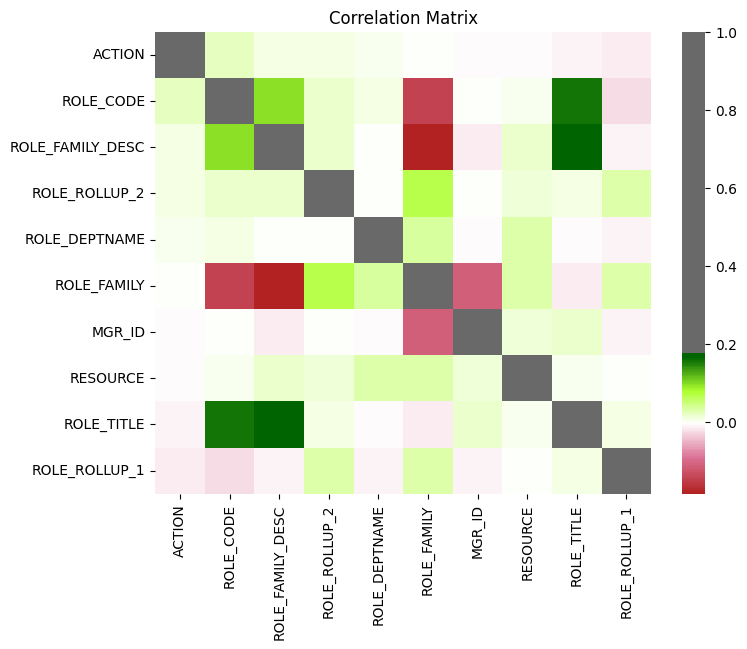

In [7]:
myCmap = makeCmap(sortedCorr) # Make cmap for heat map so I can tell what's going on

fig = plt.figure(figsize=(8, 6))
dataplot = sns.heatmap(sortedCorr, cmap=myCmap)
plt.title("Correlation Matrix")

plt.show()

ACTION              1.000000
ROLE_CODE           0.020044
ROLE_FAMILY_DESC    0.009946
ROLE_ROLLUP_2       0.006315
ROLE_DEPTNAME       0.001889
ROLE_FAMILY        -0.001394
MGR_ID             -0.004053
RESOURCE           -0.006446
ROLE_TITLE         -0.009851
ROLE_ROLLUP_1      -0.015538
Name: ACTION, dtype: float64


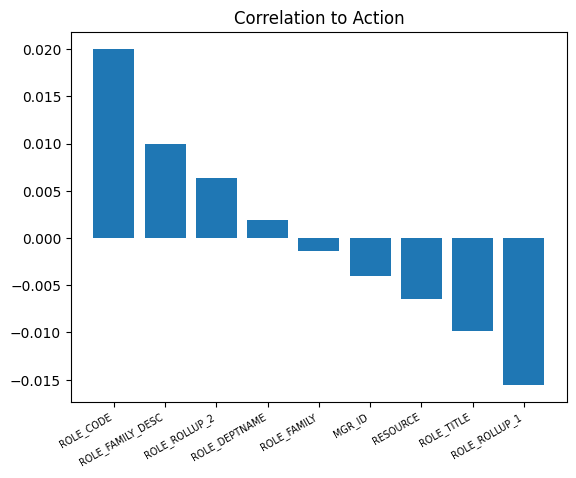

In [8]:
labelCorr = sortedCorr["ACTION"]
print(sortedCorr["ACTION"])
figure, ax = plt.subplots()
plt.bar(labelCorr.index[1:], list(labelCorr)[1:])
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize='x-small')
plt.title("Correlation to Action")
plt.show()

In [9]:
# ROLE_DEPTNAME and ROLE_FAMILY have very low correlations to ACTION ==> Drop them
X.drop(["ROLE_DEPTNAME", "ROLE_FAMILY"], axis=1, inplace=True)
X

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_CODE
24033,76844,7344,117961,118225,123648,127917,123650
1389,25993,48583,117926,118124,117879,117886,117880
19917,79092,205,117961,118386,118321,117906,118322
22516,15064,49388,118887,118888,118293,301534,118296
2303,25553,13765,117918,117919,145648,123191,163313
...,...,...,...,...,...,...,...
5929,20298,46788,117929,117940,118568,163031,118570
11039,74001,12240,118090,118091,179731,133533,117973
4220,41643,14638,117961,118052,117905,117906,117908
6682,74701,6299,117961,117962,118321,118448,118322


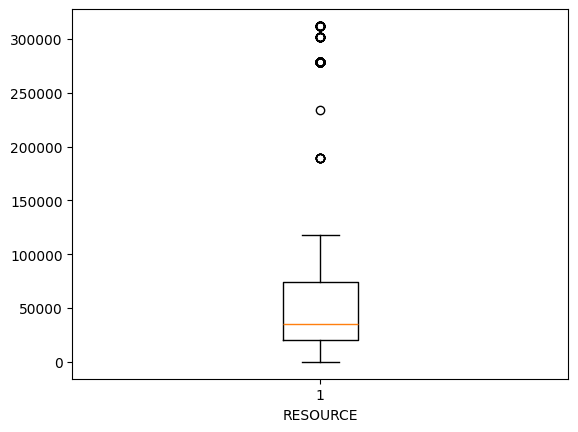

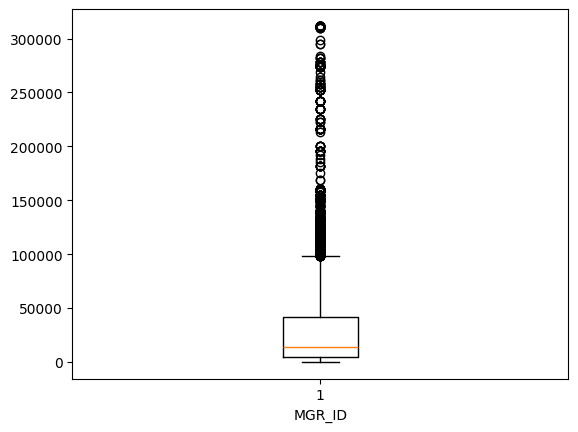

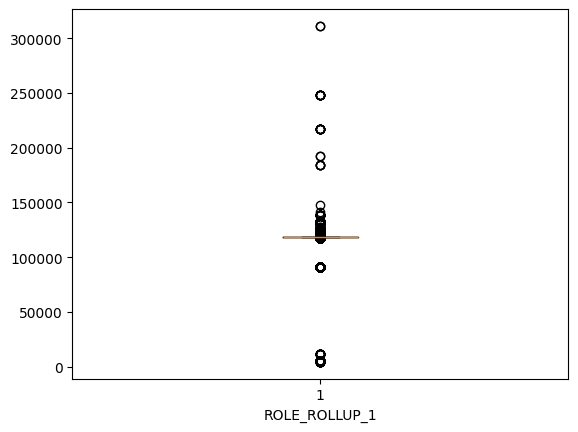

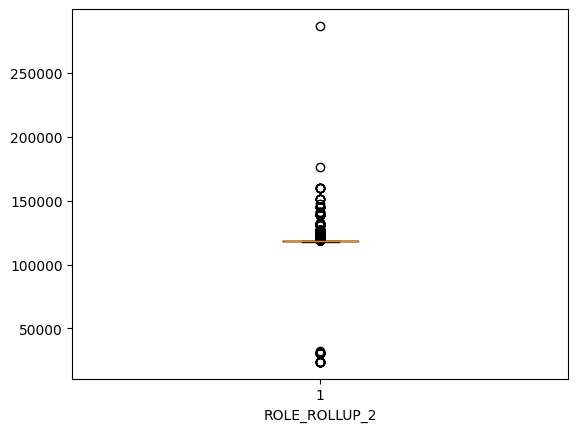

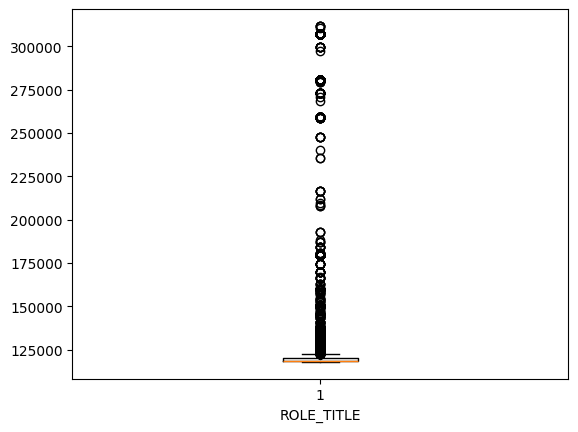

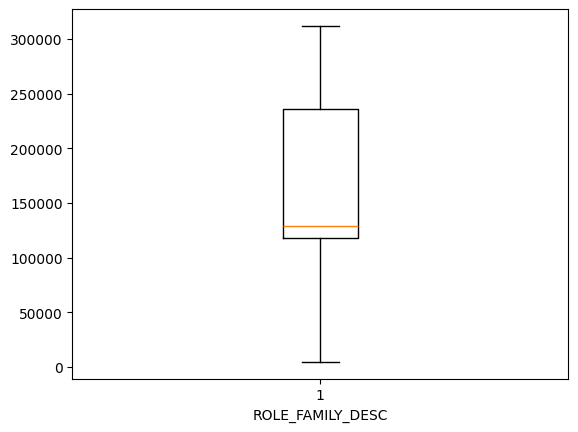

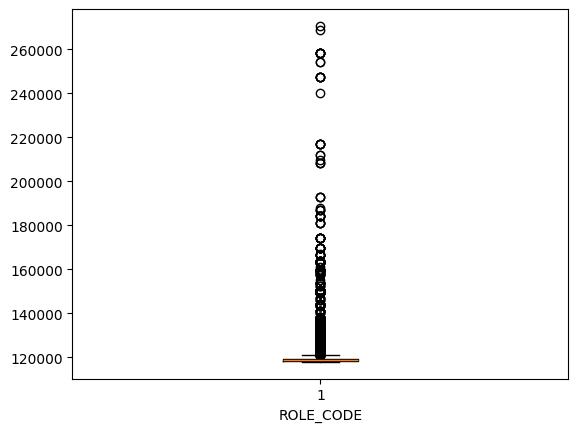

In [10]:
# Box plots to find outliers
for col in X.columns:
    fig = plt.figure()
    plt.boxplot(X[col])
    plt.xlabel(col)
    plt.show()

In [11]:
# ROLE_ROLLUP 2 has outliers ==> drop outliers
outliers = list(X[X["ROLE_ROLLUP_2"] > 250_000].index)
print(outliers)


X.drop(outliers, axis=0, inplace=True)
y.drop(outliers, axis=0, inplace=True)


X[X["ROLE_ROLLUP_2"] > 250_000]

[4406]


,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_CODE


ACTION
1         23168
0          1407
Name: count, dtype: int64


Text(0.5, 1.0, 'Label Composition')

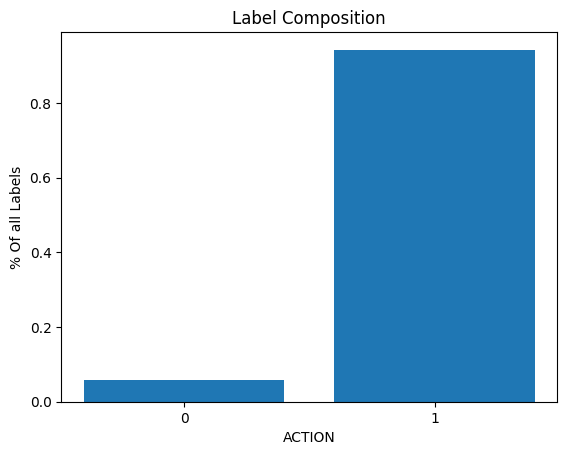

In [12]:
labelCount = y.value_counts()
print(labelCount)

figure = plt.figure()
plt.bar(['0', '1'], [labelCount[0] / len(y), labelCount[1] / len(y)])
plt.xlabel("ACTION")
plt.ylabel("% Of all Labels")
plt.title("Label Composition")

**Changing order of data scaling**

In [13]:
# Change to numpy array
y = np.array(y["ACTION"])

# Split the data set into training and validation
Xtrain, Xval, yTrain, yVal = train_test_split(
    X, y, test_size = 0.2, shuffle = True, random_state=321)

# Scale data
scaler   = StandardScaler()
XtrainScaled = scaler.fit_transform(Xtrain) # Fit
XvalScaled = scaler.transform(Xval) # DO NOT FIT
XtestScaled = scaler.transform(Xtest) # DO NOT FIT

# Unbalanced dataset ==> resample training set with SMOTE
# https://medium.com/@corymaklin/synthetic-minority-over-sampling-technique-smote-7d419696b88c
smote = SMOTE(sampling_strategy="minority", random_state=321)
XtrainScaled, yTrain = smote.fit_resample(XtrainScaled, yTrain)


In [14]:
# convert data from numpy to tensors
XtrainT = torch.from_numpy(XtrainScaled).float()
yTrainT = torch.flatten(torch.from_numpy(yTrain).long())
XvalT   = torch.from_numpy(XvalScaled).float()
yValT   = torch.flatten(torch.from_numpy(yVal).long())
XtestT = torch.from_numpy(XtestScaled).float()
yTestT = torch.flatten(torch.from_numpy(yTest).long())


print(XtrainT.shape, yTrainT.shape)
print(XtrainT.dtype, yTrainT.dtype)

torch.Size([37032, 7]) torch.Size([37032])
torch.float32 torch.int64


In [15]:
# Split into batches
trainData = [(XtrainT[i], yTrainT[i]) for i in range(XtrainT.shape[0])]
trainLoader = torch.utils.data.DataLoader(trainData, batch_size = 16, shuffle=True)

testData = [(XvalT[i], yValT[i]) for i in range(XvalT.shape[0])]
testLoader = torch.utils.data.DataLoader(testData, batch_size = 8)

## Training

In [16]:
class Model(nn.Module):
    def __init__(self, input_dim = 7):
        super(Model, self).__init__()

        self.layer1    = nn.Linear(in_features = input_dim, out_features = 35)
        self.dropout1 = nn.Dropout(p = 0.3)

        self.layer2    = nn.Linear(in_features= 35, out_features = 28)
        self.dropout2 = nn.Dropout(p = 0.25)

        self.layer3    = nn.Linear(in_features = 28, out_features = 2)


    def forward(self, x):
        x = functional.relu(self.layer1(x))
        x = self.dropout1(x)
        x = functional.relu(self.layer2(x))
        x = self.dropout2(x)
        x = self.layer3(x) # Activations for binary labels
        return x


In [17]:
model = Model(Xtrain.shape[1])

# Hyperparameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossFunc   = nn.CrossEntropyLoss()

In [18]:
def train_model(nEpochs, model, trainLoader, testLoader, optimizer, lossFunc):
    # For graphing
    trainResults = {"epochs": [], "loss": [], "accuracy": []}
    valResults = {"epochs": [], "loss": [], "accuracy": []}
    bestResults = None
    bestModel = None

    for epoch in range(nEpochs+1):
      print(f"Epoch: {epoch}")

      model.train()

      runningLoss = 0.0
      correct = 0
      total = 0

      for Xbatch, yBatch in trainLoader: # for each batch
        # Set gradients to 0
        optimizer.zero_grad()

        # Forward pass
        yPred = model.forward(Xbatch)
        loss = lossFunc(yPred,yBatch)

        # Backwards pass
        loss.backward()

        # Adjust weights
        optimizer.step()

        # compute loss, predicted, total,
        runningLoss += loss.item()
        _, predicted = torch.max(yPred.data, 1)
        total   += yBatch.size(0)
        correct += (predicted == yBatch).sum().item()

      acc = 100 * correct / total # accuracy
      trainLossAvg = runningLoss / len(trainLoader)

      print(f"\tTraining: Loss = {trainLossAvg:.4f}, Accuracy = {acc:.4f}")
      trainResults["epochs"].append(epoch)
      trainResults["loss"].append(trainLossAvg)
      trainResults["accuracy"].append(acc)

      if epoch == 1 or epoch % 5 == 0:
        # No dropout for validation
        model.eval()

        valRunningLoss = 0.0
        valCorrect = 0
        valTotal = 0

        # No learning for validation
        with torch.no_grad():
          for Xbatch, yBatch in testLoader:
            yPredVal = model.forward(Xbatch)
            lossVal = lossFunc(yPredVal, yBatch)

            valRunningLoss += lossVal
            _, predicted = torch.max(yPredVal.data, 1)
            valTotal   += yBatch.size(0)
            valCorrect += (predicted == yBatch).sum().item()

          valAcc = 100 * valCorrect / valTotal
          valLossAvg = valRunningLoss / len(testLoader)

          print(f"\tValidation: Loss = {valLossAvg:.4f}, Accuracy = {valAcc:.4f}")
          valResults["epochs"].append(epoch)
          valResults["loss"].append(valLossAvg)
          valResults["accuracy"].append(valAcc)

          if(bestResults == None):
            bestResults = (valLossAvg, epoch)

          # If current loss better than best loss
          elif valLossAvg < bestResults[0]: 
            bestResults = (valLossAvg, epoch)
            bestModel = copy.copy(model) # Save copy of current best model
    
    model = bestModel # Revert to model with least loss
    return trainResults, valResults, bestResults[1]

In [19]:

trainResults, valResults, bestEpoch = train_model(nEpochs = 50, model = model,
            trainLoader = trainLoader, testLoader = testLoader, optimizer = optimizer,
            lossFunc = lossFunc)

Epoch: 0
	Training: Loss = 0.6841, Accuracy = 54.7283
	Validation: Loss = 0.7188, Accuracy = 44.0895
Epoch: 1
	Training: Loss = 0.6739, Accuracy = 57.7258
	Validation: Loss = 0.6556, Accuracy = 61.7091
Epoch: 2
	Training: Loss = 0.6701, Accuracy = 58.2118
Epoch: 3
	Training: Loss = 0.6649, Accuracy = 59.3568
Epoch: 4
	Training: Loss = 0.6606, Accuracy = 60.0724
Epoch: 5
	Training: Loss = 0.6581, Accuracy = 60.1912
	Validation: Loss = 0.6871, Accuracy = 61.6277
Epoch: 6
	Training: Loss = 0.6565, Accuracy = 60.5260
Epoch: 7
	Training: Loss = 0.6536, Accuracy = 60.6881
Epoch: 8
	Training: Loss = 0.6505, Accuracy = 61.1795
Epoch: 9
	Training: Loss = 0.6485, Accuracy = 61.3307
Epoch: 10
	Training: Loss = 0.6457, Accuracy = 61.6575
	Validation: Loss = 0.6377, Accuracy = 67.3449
Epoch: 11
	Training: Loss = 0.6457, Accuracy = 61.6089
Epoch: 12
	Training: Loss = 0.6440, Accuracy = 62.2111
Epoch: 13
	Training: Loss = 0.6420, Accuracy = 62.3110
Epoch: 14
	Training: Loss = 0.6411, Accuracy = 62.45

### Graph Training Statistics

In [25]:
# I messed up the code to put this data in arrays so we're
# copy/pasting it from above into a text editor and using regex to make them arrays of dicts

'''
trainData = [{"epoch": 0, "loss": 0.6854, "accuracy": 54.1114}, {"epoch": 1, "loss": 0.6778, "accuracy": 56.0699}, {"epoch": 2, "loss": 0.6742, "accuracy": 57.0222}, {"epoch": 3, "loss": 0.6705, "accuracy": 58.0339}, {"epoch": 4, "loss": 0.6682, "accuracy": 58.1553}, {"epoch": 5, "loss": 0.6656, "accuracy": 58.7812}, {"epoch": 6, "loss": 0.6620, "accuracy": 59.4421}, {"epoch": 7, "loss": 0.6614, "accuracy": 59.2695}, {"epoch": 8, "loss": 0.6585, "accuracy": 60.1894}, {"epoch": 9, "loss": 0.6558, "accuracy": 60.2110}, {"epoch": 10, "loss": 0.6537, "accuracy": 60.8099}, {"epoch": 11, "loss": 0.6533, "accuracy": 60.9636}, {"epoch": 12, "loss": 0.6507, "accuracy": 61.5356}, {"epoch": 13, "loss": 0.6488, "accuracy": 61.4762}, {"epoch": 14, "loss": 0.6480, "accuracy": 61.8944}, {"epoch": 15, "loss": 0.6461, "accuracy": 62.1210}, {"epoch": 16, "loss": 0.6443, "accuracy": 62.2747}, {"epoch": 17, "loss": 0.6436, "accuracy": 62.7199}, {"epoch": 18, "loss": 0.6400, "accuracy": 63.0571}, {"epoch": 19, "loss": 0.6388, "accuracy": 63.3781}, {"epoch": 20, "loss": 0.6391, "accuracy": 63.5103}, {"epoch": 21, "loss": 0.6357, "accuracy": 63.9204}, {"epoch": 22, "loss": 0.6368, "accuracy": 63.8934}, {"epoch": 23, "loss": 0.6341, "accuracy": 64.0633}, {"epoch": 24, "loss": 0.6343, "accuracy": 64.5193}, {"epoch": 25, "loss": 0.6306, "accuracy": 64.5867}, {"epoch": 26, "loss": 0.6305, "accuracy": 64.1955}, {"epoch": 27, "loss": 0.6316, "accuracy": 64.3628}, {"epoch": 28, "loss": 0.6279, "accuracy": 64.6110}, {"epoch": 29, "loss": 0.6268, "accuracy": 65.0156}, {"epoch": 30, "loss": 0.6253, "accuracy": 65.1667}, {"epoch": 31, "loss": 0.6266, "accuracy": 64.8862}, {"epoch": 32, "loss": 0.6253, "accuracy": 65.3879}, {"epoch": 33, "loss": 0.6256, "accuracy": 65.0750}, {"epoch": 34, "loss": 0.6264, "accuracy": 65.1721}, {"epoch": 35, "loss": 0.6226, "accuracy": 65.4473}, {"epoch": 36, "loss": 0.6224, "accuracy": 65.6307}, {"epoch": 37, "loss": 0.6218, "accuracy": 65.5174}, {"epoch": 38, "loss": 0.6237, "accuracy": 65.3960}, {"epoch": 39, "loss": 0.6196, "accuracy": 65.9032}, {"epoch": 40, "loss": 0.6221, "accuracy": 65.6577}]
valResults = [{"epoch": 0, "loss":  0.6764, "accuracy": 57.3263}, {"epoch": 1, "loss":  0.6703, "accuracy": 58.5995}, {"epoch": 5, "loss":  0.6550, "accuracy": 60.2180}, {"epoch": 10, "loss":  0.6396, "accuracy": 63.3038}, {"epoch": 15, "loss":  0.6251, "accuracy": 64.8360}, {"epoch": 20, "loss":  0.6144, "accuracy": 66.9940}, {"epoch": 25, "loss":  0.6099, "accuracy": 66.8213}, {"epoch": 30, "loss":  0.5991, "accuracy": 68.6340}, {"epoch": 35, "loss":  0.5939, "accuracy": 69.0009}, {"epoch": 40, "loss":  0.5947, "accuracy": 69.2382}]

trainEpochs = [item['epoch'] for item in trainData]
trainLoss = [item['loss'] for item in trainData]
trainAcc = [item['accuracy'] for item in trainData]

valEpochs = [item['epoch'] for item in valResults]
valLoss = [item['loss'] for item in valResults]
valAcc = [item['accuracy'] for item in valResults]
'''

'\ntrainData = [{"epoch": 0, "loss": 0.6854, "accuracy": 54.1114}, {"epoch": 1, "loss": 0.6778, "accuracy": 56.0699}, {"epoch": 2, "loss": 0.6742, "accuracy": 57.0222}, {"epoch": 3, "loss": 0.6705, "accuracy": 58.0339}, {"epoch": 4, "loss": 0.6682, "accuracy": 58.1553}, {"epoch": 5, "loss": 0.6656, "accuracy": 58.7812}, {"epoch": 6, "loss": 0.6620, "accuracy": 59.4421}, {"epoch": 7, "loss": 0.6614, "accuracy": 59.2695}, {"epoch": 8, "loss": 0.6585, "accuracy": 60.1894}, {"epoch": 9, "loss": 0.6558, "accuracy": 60.2110}, {"epoch": 10, "loss": 0.6537, "accuracy": 60.8099}, {"epoch": 11, "loss": 0.6533, "accuracy": 60.9636}, {"epoch": 12, "loss": 0.6507, "accuracy": 61.5356}, {"epoch": 13, "loss": 0.6488, "accuracy": 61.4762}, {"epoch": 14, "loss": 0.6480, "accuracy": 61.8944}, {"epoch": 15, "loss": 0.6461, "accuracy": 62.1210}, {"epoch": 16, "loss": 0.6443, "accuracy": 62.2747}, {"epoch": 17, "loss": 0.6436, "accuracy": 62.7199}, {"epoch": 18, "loss": 0.6400, "accuracy": 63.0571}, {"epoc

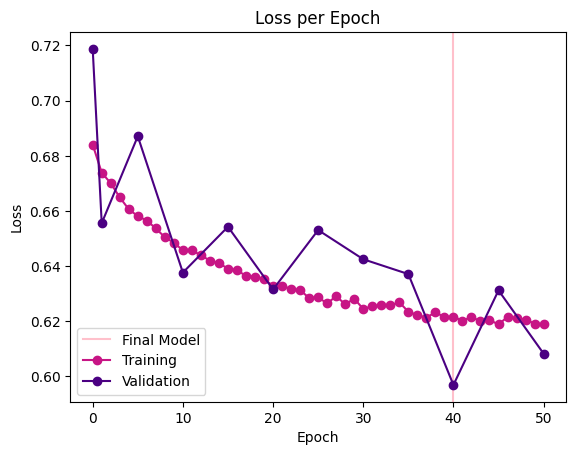

In [26]:
# Plot Loss
figure = plt.figure()

# Best epoch
plt.axvline(x = bestEpoch, label = "Final Model", color = "pink")

# Training data
plt.plot(trainResults["epochs"], trainResults["loss"], label="Training", color="mediumvioletred", marker="o")

# Validation data
plt.plot(valResults["epochs"], valResults["loss"], label="Validation", color="indigo", marker="o")


plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

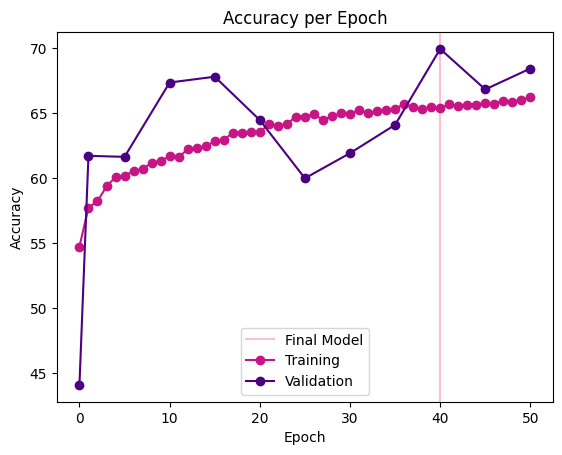

In [27]:
# Plot Accuracy
figure = plt.figure()

# Best epoch
plt.axvline(x = bestEpoch, label = "Final Model", color = "pink")

# Training data
plt.plot(trainResults["epochs"], trainResults["accuracy"], label="Training", color="mediumvioletred", marker="o")

# Validation data
plt.plot(valResults["epochs"], valResults["accuracy"], label="Validation", color="indigo", marker="o")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

## Evaluation

In [28]:
def confusionMatrix(yTrue, yPred, setName):
  cm = confusion_matrix(yTrue, yPred,)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap="RdPu")
  plt.title(setName)
  plt.show()


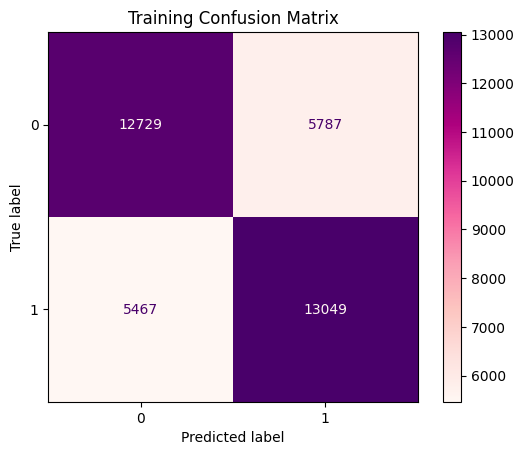

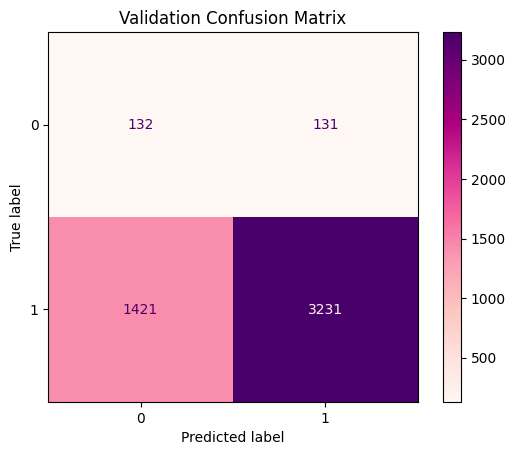

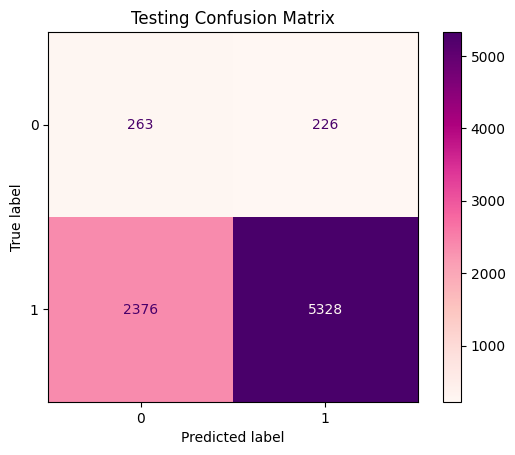

In [134]:
# Normalize with softmax
softMax = torch.nn.Softmax(1)

yPredTrain = softMax(model.forward(XtrainT))
yPredTrain = torch.argmax(yPredTrain,dim = 1)
correctPredTrain = torch.sum(yPredTrain == yTrainT) / yPredTrain.shape[0]
trainF1 = f1_score(yTrainT, yPredTrain)

yPredVal = softMax(model.forward(XvalT))
yPredVal = torch.argmax(yPredVal,dim = 1)
correctPredVal = torch.sum(yPredVal == yValT) / yPredVal.shape[0]
valF1 = f1_score(yValT, yPredVal)


yPredTest = softMax(model.forward(XtestT))
yPredTest = torch.argmax(yPredTest, dim = 1)
correctPredTest = torch.sum(yPredTest == yTestT) / yPredTest.shape[0]
testF1 = f1_score(yTestT, yPredTest)

confusionMatrix(yTrainT, yPredTrain, f"Training Confusion Matrix")
confusionMatrix(yVal, yPredVal, f"Validation Confusion Matrix")
confusionMatrix(yTestT, yPredTest, f"Testing Confusion Matrix")

In [135]:
#https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
def add_labels(x, y, offset=0):
    for i in range(len(x)):
        plt.text(i+ offset, y[i]+0.005, y[i])  # Placing text slightly above the bar

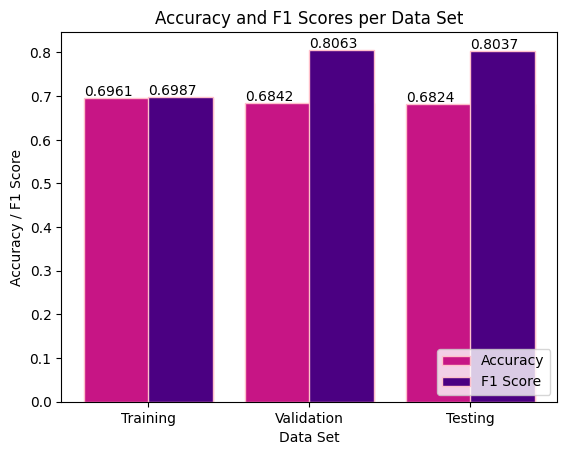

In [136]:
# Bar chart for accuracies
fig, ax = plt.subplots()

plt.bar(["Training", "Validation", "Testing"], [correctPredTrain, correctPredVal, correctPredTest], width=0.8, color="mediumvioletred", edgecolor="pink")
add_labels(["Training", "Validation", "Testing"], [round(correctPredTrain.item(), 4), round(correctPredVal.item(), 4), round(correctPredTest.item(), 4)], -0.4)

plt.bar(["Training", "Validation", "Testing"], [trainF1, valF1, testF1], width=0.4, align="edge", color="indigo", edgecolor="pink")
add_labels(["Training", "Validation", "Testing"], [round(trainF1.item(), 4), round(valF1.item(), 4), round(testF1.item(), 4)])

plt.legend(labels=["Accuracy", "F1 Score"], loc="lower right")
plt.ylabel("Accuracy / F1 Score")
plt.xlabel("Data Set")
plt.title("Accuracy and F1 Scores per Data Set")

plt.show()